In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Resizing, Rescaling, RandomFlip, RandomZoom, RandomBrightness, RandomContrast,RandomRotation
from keras.utils import image_dataset_from_directory
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.applications import EfficientNetV2L
from keras.applications import EfficientNetV2S
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.losses import SparseCategoricalCrossentropy as scc
f'Tensorflow version: {tf.__version__}'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'Tensorflow version: 2.12.0'

In [2]:
imagesize = 256
batchsize = 32
rand_seed = 10

train_ds = image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Monkeypox/Monkeypox',
    image_size = (imagesize, imagesize),
    batch_size = batchsize,
    validation_split = 0.2,
    subset = 'training',
    labels = 'inferred',
    shuffle = True,
    seed = rand_seed
)

valid_ds = image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Monkeypox/Monkeypox',
    image_size = (imagesize, imagesize),
    batch_size = batchsize,
    validation_split = 0.2,
    subset = 'validation',
    labels = 'inferred',
    shuffle = True,
    seed = rand_seed
)

Found 3192 files belonging to 2 classes.
Using 2554 files for training.
Found 3192 files belonging to 2 classes.
Using 638 files for validation.


In [3]:
class_names = train_ds.class_names

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
base_model = EfficientNetV2L(include_top=False,
    weights='imagenet',
    input_shape=(imagesize, imagesize, 3))
base_model.trainable = False

473176280/473176280 [==============================] - 2s 0us/step


In [6]:
base_model.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [7]:
data_augmentation = Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
    #Rescaling(1./255),
    RandomZoom(height_factor=(-0.2, 0.2), width_factor = (-0.2, 0.2))
])

In [8]:
es = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, restore_best_weights=True)

In [9]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
init_lr = 0.0005

In [11]:
def schedule(epoch,lr):
    if epoch < 5:
        return lr + init_lr
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(schedule,verbose=1)

In [12]:
def create_model(base_model):
    input = Input(shape=(imagesize, imagesize, 3))
    x = data_augmentation(input)
    b_model = base_model(x)
    flatten = Flatten()(b_model)
    x = Dense(1024,activation='relu')(flatten)
    norm = BatchNormalization()(x)
    x = Dense(512,activation='relu')(norm)
    norm = BatchNormalization()(x)
    x = Dense(512,activation='relu')(norm)
    norm = BatchNormalization()(x)
    x = Dense(128,activation='relu')(norm)
    norm = BatchNormalization()(x)
    dropout = Dropout(0.2)(norm)
    x = Dense(len(class_names))(dropout)
    model = tf.keras.models.Model(inputs=input, outputs=x)
    
    model.compile(optimizer=Adam(init_lr),
              loss=scc(from_logits=True),
              metrics=['accuracy'])
    return model

In [13]:
model = create_model(base_model)

In [14]:
epochs = 50

In [15]:
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=valid_ds,
                   callbacks=[es,lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000237487257.
Epoch 1/50


2023-10-15 09:09:59.745214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


80/80 [==============================] - 73s 508ms/step - loss: 0.7292 - accuracy: 0.6899 - val_loss: 0.7451 - val_accuracy: 0.7602 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0015000000474974513.
Epoch 2/50
80/80 [==============================] - 31s 389ms/step - loss: 0.5410 - accuracy: 0.7635 - val_loss: 0.3371 - val_accuracy: 0.8621 - lr: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.002000000013038516.
Epoch 3/50
80/80 [==============================] - 31s 384ms/step - loss: 0.4552 - accuracy: 0.8007 - val_loss: 0.3933 - val_accuracy: 0.8699 - lr: 0.0020

Epoch 4: LearningRateScheduler setting learning rate to 0.0025000000949949026.
Epoch 4/50
80/80 [==============================] - 31s 386ms/step - loss: 0.3920 - accuracy: 0.8336 - val_loss: 0.3268 - val_accuracy: 0.8856 - lr: 0.0025

Epoch 5: LearningRateScheduler setting learning rate to 0.003000000176951289.
Epoch 5/50
80/80 [==============================] - 30s 371ms/step - 

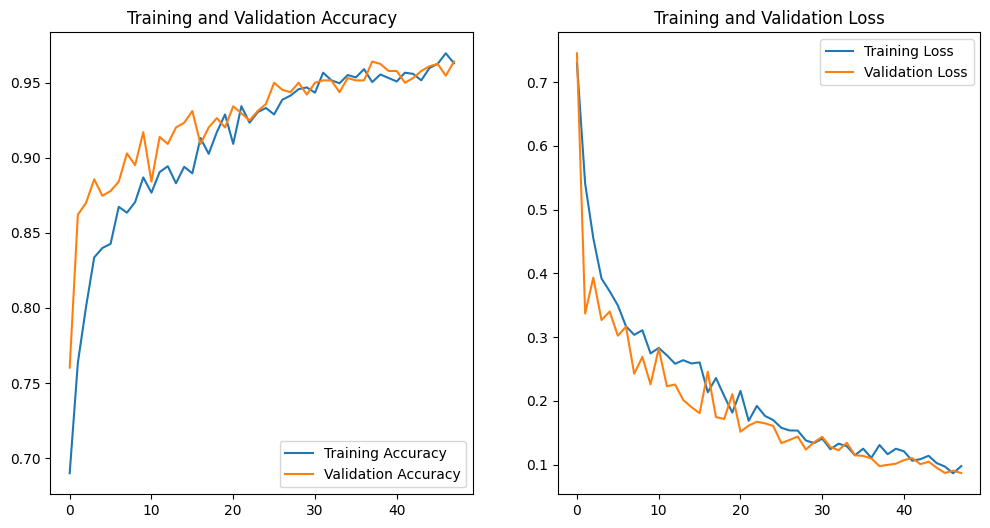

In [16]:
plot_history(history)

In [17]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block7a_expand_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_1 False
rescaling False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1a_add False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block1c_project_conv False
block1c_project_bn False
block1c_project_activation False
block1c_drop False
block1c_add False
block1d_project_conv False
block1d_project_bn False
block1d_project_activation False
block1d_drop False
block1d_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_bn False
block2c_dr

In [18]:
init_lr = 0.0001

In [19]:
model = create_model(base_model)

In [20]:
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=valid_ds,
                   callbacks=[es,lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001999999974737875.
Epoch 1/50


2023-10-15 09:36:45.631546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


80/80 [==============================] - 78s 622ms/step - loss: 0.6551 - accuracy: 0.7326 - val_loss: 0.2828 - val_accuracy: 0.8777 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.000299999994947575.
Epoch 2/50
80/80 [==============================] - 37s 464ms/step - loss: 0.3622 - accuracy: 0.8684 - val_loss: 0.2366 - val_accuracy: 0.9263 - lr: 3.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0003999999851454049.
Epoch 3/50
80/80 [==============================] - 37s 464ms/step - loss: 0.2298 - accuracy: 0.9072 - val_loss: 0.1712 - val_accuracy: 0.9498 - lr: 4.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0004999999898951501.
Epoch 4/50
80/80 [==============================] - 37s 464ms/step - loss: 0.2115 - accuracy: 0.9225 - val_loss: 0.1329 - val_accuracy: 0.9687 - lr: 5.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005999999655410648.
Epoch 5/50
80/80 [==============================] - 

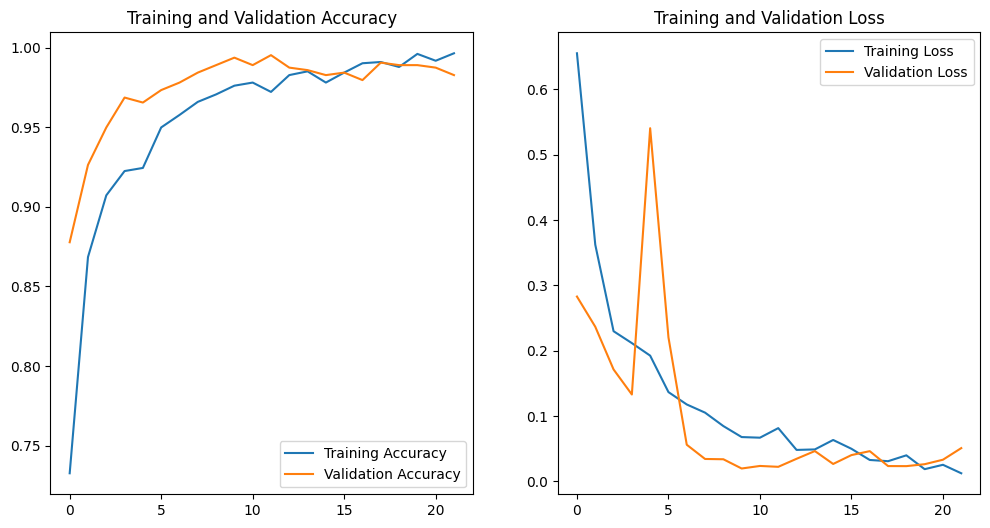

In [21]:
plot_history(history)

In [22]:
model.save('Monkeypox.h5')